In [2]:
# The example tries to determine the influenced factor of education outcomes for hearing-impaired children
# link: https://www.pymc.io/projects/docs/en/latest/learn/core_notebooks/pymc_overview.html#discussion
import numpy as np
import pymc as pm
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az



WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
test_scores = pd.read_csv(pm.get_data("test_scores.csv"), index_col=0)
test_scores.head()


,score,male,siblings,family_inv,non_english,prev_disab,age_test,non_severe_hl,mother_hs,early_ident,non_white
0,40,0,2.0,2.0,False,NaN,55,1.0,NaN,False,False
1,31,1,0.0,NaN,False,0.0,53,0.0,0.0,False,False
2,83,1,1.0,1.0,True,0.0,52,1.0,NaN,False,True
3,75,0,3.0,NaN,False,0.0,55,0.0,1.0,False,False
5,62,0,0.0,4.0,False,1.0,50,0.0,NaN,False,False


<Axes: >

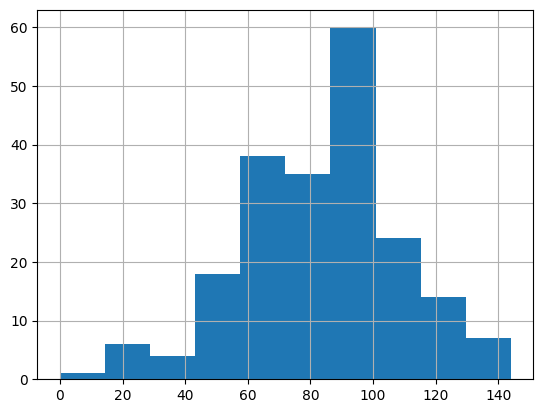

In [4]:
test_scores["score"].hist()

In [5]:
# Dropping missing values is a very bad idea in general, but we do so here for simplicity
X = test_scores.dropna().astype(float)
y = X.pop("score")

# Standardize the features
X -= X.mean()
X /= X.std()

N, D = X.shape

In [6]:
D0 = int(D / 2)

In [7]:
import pytensor.tensor as at

with pm.Model(coords={"predictors": X.columns.values}) as test_score_model:
    # Prior on error SD
    sigma = pm.HalfNormal("sigma", 25)

    # Global shrinkage prior
    tau = pm.HalfStudentT("tau", 2, D0 / (D - D0) * sigma / np.sqrt(N))
    # Local shrinkage prior
    lam = pm.HalfStudentT("lam", 5, dims="predictors")
    c2 = pm.InverseGamma("c2", 1, 1)
    z = pm.Normal("z", 0.0, 1.0, dims="predictors")
    # Shrunken coefficients
    beta = pm.Deterministic(
        "beta", z * tau * lam * at.sqrt(c2 / (c2 + tau**2 * lam**2)), dims="predictors"
    )
    # No shrinkage on intercept
    beta0 = pm.Normal("beta0", 100, 25.0)

    scores = pm.Normal("scores", beta0 + at.dot(X.values, beta), sigma, observed=y.values)

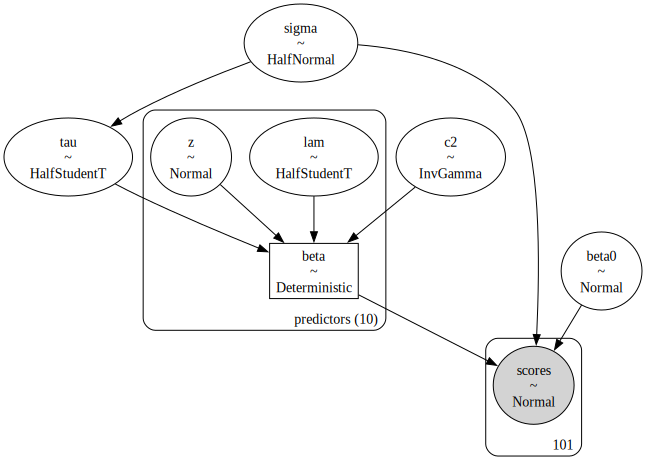

In [8]:
pm.model_to_graphviz(test_score_model)

In [9]:
with test_score_model:
    prior_samples = pm.sample_prior_predictive(100)

Sampling: [beta0, c2, lam, scores, sigma, tau, z]


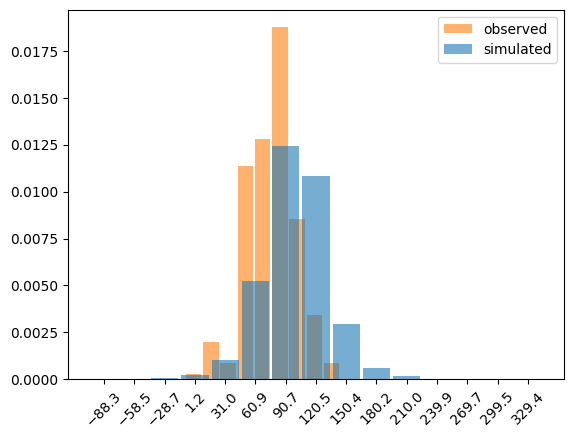

In [10]:
az.plot_dist(
    test_scores["score"].values,
    kind="hist",
    color="C1",
    hist_kwargs=dict(alpha=0.6),
    label="observed",
)
az.plot_dist(
    prior_samples.prior_predictive["scores"],
    kind="hist",
    hist_kwargs=dict(alpha=0.6),
    label="simulated",
)
plt.xticks(rotation=45)

In [11]:
with test_score_model:
    idata = pm.sample(1000, tune=2000, random_seed=42)

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytensor\tensor\elemwise.py:753: RuntimeWarning: divide by zero encountered in divide
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytensor\tensor\rewriting\elemwise.py:1028: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytensor\tensor\elemwise.py:753: RuntimeWarning: divide by zero encountered in divide
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytensor\tensor\elemwise.py:753: RuntimeWarning: divide by zero encountered in divide
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytensor

Output()

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytensor\tensor\elemwise.py:753: RuntimeWarning: divide by zero encountered in divide
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytensor\tensor\elemwise.py:753: RuntimeWarning: divide by zero encountered in divide
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytensor\tensor\elemwise.py:753: RuntimeWarning: divide by zero encountered in divide
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytensor\tensor\elemwise.py:753: RuntimeWarning: divide by zero encountered in divide
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytensor\tensor\elemwise.py:753: RuntimeWarning: divide by zero encountered in divide
  variables = 

In [12]:
with test_score_model:
    idata = pm.sample(1000, tune=2000, random_seed=42, target_accept=0.99)

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytensor\tensor\elemwise.py:753: RuntimeWarning: divide by zero encountered in divide
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytensor\tensor\rewriting\elemwise.py:1028: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytensor\tensor\elemwise.py:753: RuntimeWarning: divide by zero encountered in divide
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytensor\tensor\elemwise.py:753: RuntimeWarning: divide by zero encountered in divide
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytensor

Output()

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytensor\tensor\elemwise.py:753: RuntimeWarning: divide by zero encountered in divide
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytensor\tensor\elemwise.py:753: RuntimeWarning: divide by zero encountered in divide
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytensor\tensor\elemwise.py:753: RuntimeWarning: divide by zero encountered in divide
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytensor\tensor\elemwise.py:753: RuntimeWarning: divide by zero encountered in divide
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytensor\tensor\elemwise.py:753: RuntimeWarning: divide by zero encountered in divide
  variables = 

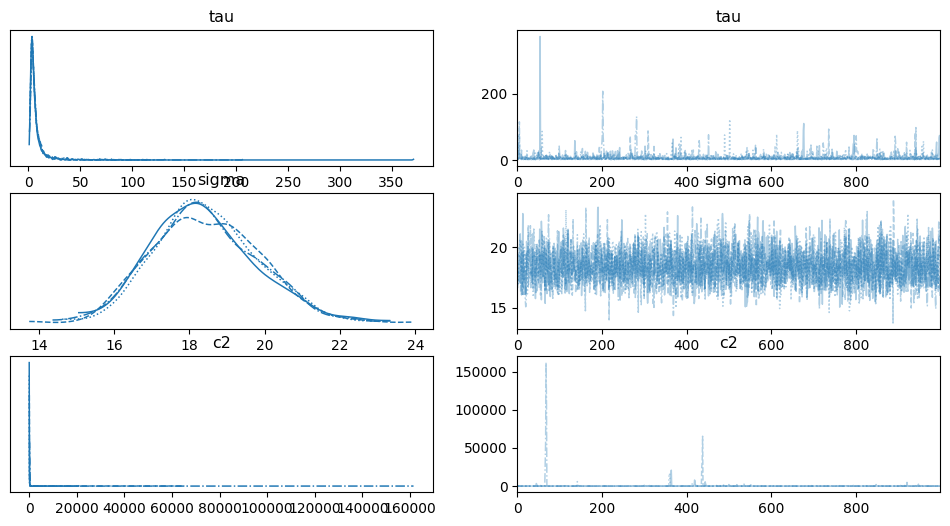

In [13]:
az.plot_trace(idata, var_names=["tau", "sigma", "c2"])